In [93]:
import torch #Redes neuronales
import pandas as pd #Dataframes
from torchvision.models import resnet50 #Importar una red neuroles
from PIL import Image #Librería para trabajar con imágenes 
from torchvision.datasets import ImageFolder #Localizar una carpeta y sus imagenes
from torch.utils.data import DataLoader #Genera un "generador"
from torch.nn import CrossEntropyLoss #Loss function
from torch.optim import SGD   
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder                                    

In [94]:
# Definir las transformaciones para las imágene# Ajusta el tamaño y recorta según las necesidades de tu red
transform = transforms.Compose([
    transforms.Resize(256),             # Redimensiona la imagen a 256x256
    transforms.CenterCrop(224),         # Recorta el centro a 224x224
    transforms.ToTensor(),              # Convierte la imagen a un tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normaliza
])

# ⚠️ ¡IMPORTANTE! Reemplaza esto con la ruta a tu carpeta de Pokémon
data_dir = "C://Users//sebas//Downloads//archive (13)//PokemonData"

# Cargar todo el dataset usando ImageFolder
full_dataset = ImageFolder(root=data_dir, transform=transform)

# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Crear los DataLoaders para entrenamiento y prueba
# Puedes ajustar el batch_size (en el código original era 4)
trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

# Obtener los nombres de las clases (los Pokémon) automáticamente de las carpetas
classes = full_dataset.classes
print("Clases detectadas en tu dataset:", classes)

Clases detectadas en tu dataset: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres',

In [95]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = ImageFolder(root="C://Users//sebas//Downloads//archive (13)//PokemonData", transform=transform)
dataloader = DataLoader(dataset, batch_size=1)

# Obtener etiquetas
labels = dataset.classes

# Suponiendo que ya hiciste una predicción con tu modelo:
# y_prob = model(batch)
index = y_prob.argmax().item()

# Mostrar clase predicha
#print("Clase predicha:", labels[index])

In [96]:
torch.cuda.is_available()

False

In [97]:
#torch.cuda.current_device()

In [98]:
#torch.cuda.get_device_name(0)

In [99]:
# Selecciona automáticamente la GPU si está disponible, de lo contrario usa la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


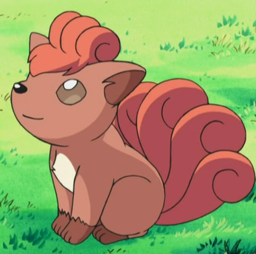

In [137]:
img = Image.open("C://Users//sebas//Downloads//archive (13)//PokemonData//Vulpix//0b8d94d6279e43cf9de8047dbcd5a058.jpg") #Open image
img.thumbnail(size=(256,256)) #Make thumnbial
img #Display

In [101]:
model = resnet50(weights="IMAGENET1K_V1") #Instanciamos el objeto
model.to(device) #Move to gpu

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [102]:
#imagenet_labels = pd.read_csv("../datasets/imagenet_labels.csv", sep = ": ")
#imagenet_labels

In [103]:
from torchvision import transforms #Transformaciones a la imagen

In [104]:
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
])

In [105]:
img_transformed = preprocessing(img).to(device)
#Transformamos la imagen
#Moverla a la GPU
img_transformed.shape

torch.Size([3, 224, 224])

In [106]:
batch = torch.unsqueeze(img_transformed, 0)
#Agregar una dimension al principio para generar un batch
batch.shape

torch.Size([1, 3, 224, 224])

In [107]:
model.eval() #Modelo en modo evaluación
y_prob = model(batch) #Evaluamos el modelo con la imagen del snoopy
y_prob.shape #Me genera la siguiente predicción

torch.Size([1, 1000])

In [109]:
index = y_prob.argmax().item()
#Lo buscamos en el dataframe de las etiquetas

In [110]:
train_folder = ImageFolder("../datasets/cats_dogs/train", transform=preprocessing) #Train
val_folder = ImageFolder("../datasets/cats_dogs/val", transform=preprocessing) #Val

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: '../datasets/cats_dogs/train'

In [112]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Ruta a tu dataset de Pokémon
data_dir = "C://Users//sebas//Downloads//archive (13)//PokemonData"

# Transformaciones para las imágenes (ajusta si es necesario)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Cargar el dataset completo
full_dataset = ImageFolder(root=data_dir, transform=transform)

# Dividir el dataset en entrenamiento (80%) y validación (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_folder, val_folder = random_split(full_dataset, [train_size, val_size])

# (Opcional) Cargar los nombres de las clases
classes = full_dataset.classes
print("Pokémon detectados:", classes)


Pokémon detectados: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'M

In [113]:
#Generadores
train_loader = DataLoader(train_folder, batch_size=32)
val_loader = DataLoader(val_folder, batch_size=32)
#Generadores de imagenes con batch size = 32
# (tamaño de cada lote)

In [114]:
for params in model.parameters():
    params.requires_grad = False
    #Congelar los gradientes de mi red

In [115]:
model.fc = torch.nn.Linear(model.fc.in_features, 2)
#Reemplazar la capa final de la red por una nueva
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [116]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(params=model.fc.parameters(), lr=1e-4) #0.0001

In [118]:
model = resnet50(pretrained=True)

# Congelar pesos de las capas anteriores si solo quieres entrenar la capa final (opcional)
for param in model.parameters():
    param.requires_grad = False

# Obtener cantidad de clases del dataset
num_classes = len(full_dataset.classes)

# Reemplazar la capa final completamente conectada (fc)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Verifica
print("Modelo ajustado con salida de", num_classes, "clases.")

c:\Users\sebas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sebas\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modelo ajustado con salida de 150 clases.


In [128]:
#Training loop
model.to(device) #Mover el modelo a la GPU
train_losses = []
val_losses = []
epochs = 2 #Seteamos un número de épocas
for epoch in range(epochs):
    model.train() #Modo entrenamiento
    train_loss = 0
    for inputs, labels in train_loader:
        #Montar los datos en la GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() #Limpiar los gradientes
        y_prob = model(inputs) #Forward pass
        loss = loss_fn(y_prob, labels) #Calcular la loss
        loss.backward() #Backward pass
        optimizer.step() #Actualizar los pesos
        train_loss += loss.item() #Sumatoria
    #Promediamos
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss) #Guardar la loss de training
    model.eval() #Modo evaluación
    val_loss = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device) #Montar los datos en la GPU
        y_prob = model(inputs) #Forward pass
        loss = loss_fn(y_prob, labels) #Calcular la loss
        val_loss += loss.item()
    #Promediamos
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss) #Guardar la loss de validacion
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")


Epoch 0, Train Loss: 5.0598885106761555, Val Loss: 5.063446621562159
Epoch 1, Train Loss: 5.0598885106761555, Val Loss: 5.063446621562159


tensor([[ 1.2130e-01,  7.3708e-01, -2.7355e-01,  2.7967e-01,  2.5128e-01,
         -4.7816e-02,  4.3755e-01, -1.1567e-01,  2.6076e-01, -2.6223e-01,
          2.5134e-01, -2.2143e-01,  4.3678e-01, -2.4441e-01,  2.3684e-01,
         -6.1989e-03, -1.6292e-01, -9.8757e-02,  7.7810e-02, -4.5001e-02,
         -1.1706e-01, -2.2233e-01,  4.0054e-01,  2.6810e-01, -1.4803e-01,
          6.5538e-03,  2.3783e-01,  6.1539e-01,  1.3677e-02,  1.3701e-01,
          5.5052e-01,  1.6848e-01,  4.4788e-01, -1.1858e-01,  3.3929e-01,
          3.5683e-01,  3.1203e-01, -4.9097e-02,  5.6846e-02,  1.3243e-01,
          8.7857e-01, -4.2563e-01,  1.7766e-03,  4.1292e-02,  2.9933e-01,
         -7.2822e-01,  2.2870e-01,  3.8203e-01,  5.5967e-01,  4.3167e-01,
         -5.3111e-03, -3.6930e-02,  2.5241e-01,  2.7275e-01, -4.2248e-01,
         -2.8385e-01,  1.3519e-01, -3.0685e-01, -6.6315e-02, -1.4061e-01,
          3.3522e-01, -5.1689e-02, -9.0880e-02,  2.7682e-02,  2.0018e-01,
         -5.3226e-01,  5.9340e-02,  6.

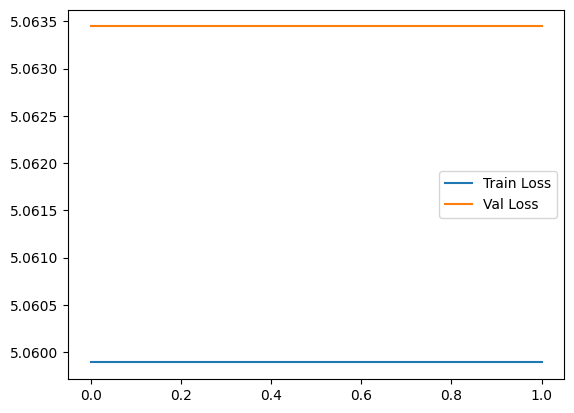

In [129]:
import seaborn as sns
sns.lineplot(x = range(epochs), y= train_losses, label = "Train Loss")
sns.lineplot(x = range(epochs), y= val_losses, label = "Val Loss")
batch.shape #Foto del snoopy
model.eval() #Modo evaluación
y_prob = model(batch) #Evaluamos el modelo con la imagen del snoopy
y_prob

In [123]:
from torch.nn import Softmax
softmax = Softmax(dim=1) #Softmax para convertir a probabilidades
y_prob = softmax(y_prob)
y_prob = y_prob.cpu().detach().numpy() #Convertir a numpy
pd.DataFrame(y_prob, columns=["Cat", "Dog"], index=["Snoopy"])

ValueError: Shape of passed values is (1, 150), indices imply (1, 2)

In [143]:
df = pd.DataFrame(y_prob.detach().cpu().numpy(), columns=classes, index=["pokemon"])
df.T.sort_values("pokemon", ascending=False).head(5)

,pokemon
Gastly,0.878573
Paras,0.825709
Aerodactyl,0.737078
Poliwhirl,0.669672
Pidgeot,0.633788


In [133]:
pred_index = y_prob.argmax()
print("Predicción:", classes[pred_index])

Predicción: Gastly


In [145]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Ruta a la imagen (puedes cambiarla)
ruta_imagen = "C://Users//sebas//Downloads//archive (13)//PokemonData//Vulpix//0b8d94d6279e43cf9de8047dbcd5a058.jpg"  # 👈 Cambia por tu imagen

# Transformaciones (deben ser las mismas que usaste en el dataset)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Cargar imagen y aplicar transformaciones
imagen = Image.open(ruta_imagen).convert("RGB")
input_tensor = transform(imagen).unsqueeze(0)  # (1, C, H, W)

# Asegúrate de que el modelo esté en modo evaluación
model.eval()

# Predecir sin gradientes
with torch.no_grad():
    output = model(input_tensor)
    probabilidades = torch.nn.functional.softmax(output, dim=1)
    pred_index = probabilidades.argmax().item()

# Mostrar resultado
print(f"El modelo predice que es: {classes[pred_index]}")

El modelo predice que es: Paras
